In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))
import setup.token_world as _tw
sys.modules["token_world"] = _tw
from setup.utils import load_world_sequences, plot_token_world, save_plot, load_model
from setup.token_world import assign_token_colors
from setup.model import GP_model
from decoding_analysis.decoder_helpers import plot_decoder, load_results
from accuracy_analysis import average_metrics, accuracy_token, plot_distribution
import numpy as np
from decoding_analysis.tuple_helpers import finalize_metrics, load_metric_files, merge_results, plot_pos_label_panels
from Intervention_analysis.intervention_helpers import compute_binned_accuracy, plot_binned_accuracy, analyze_changed_errors, plot_changed_errors_bar
import torch
from matplotlib import pyplot as plt




In [12]:
world_seqs = load_world_sequences("paper_data/sequences/pentagon_worlds.pkl", 500)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GP_model(tokens_size=26, directions_size=2,
                   embedding_size=200, hidden_size=512, output_size=26,
                   n_layers=3, layer_norm=False, dropout=0.0)
model = load_model(model, device, "paper_data/model")
    

loading checkpoint paper_data/model/final_epoch_79.pth


**Scene Example:**

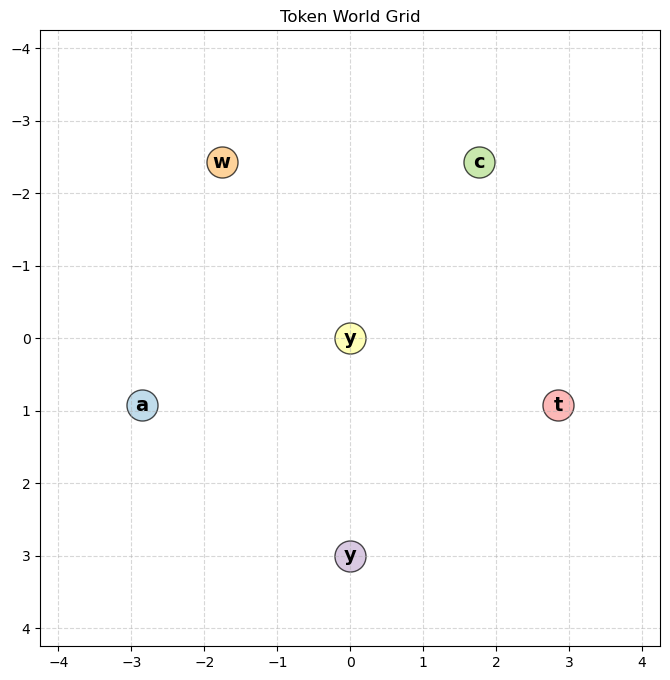

In [13]:
world  = list(world_seqs.keys())[5]
colors = assign_token_colors(world.tokens)
plot_token_world(world, colors, "Tuple Scene", save = False, graphs_dir="paper_data/graphs_dir")

**Accuracy of the Model per sequence step, averaged over 500 sequences:**

Graph saved to: paper_data/graphs_dir/0130_1949_Accuracy_per_timestep.pdf


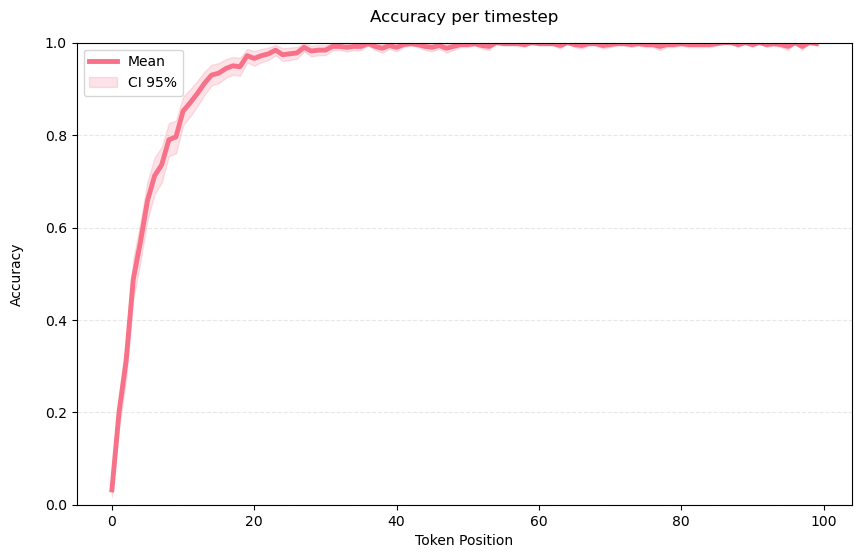

In [14]:

all_measurements = []
for world, (tokens_seq, dirs_seq) in world_seqs.items():
    world_seq = {world: (tokens_seq, dirs_seq)}
    measurements = accuracy_token(model=model, device=device, world_seq=world_seq)
    all_measurements.append(measurements)

means, stds, ns = average_metrics(all_measurements)
timesteps = sorted(means.keys())
mean_array = np.array([means[t] for t in timesteps])
std_array  = np.array([stds[t] for t in timesteps])
n_array    = np.array([ns[t]   for t in timesteps])
ci_array = 1.96 * (std_array / np.sqrt(n_array))
mean_dict = dict(zip(timesteps, mean_array))
ci_dict   = dict(zip(timesteps, ci_array))

plot_distribution(
    mean_dict,
    ci_dict,
    "paper_data/graphs_dir",
    title="Accuracy per timestep",
    ylabel= "Accuracy",
    metric="Accuracy",
)

**Label & Position Decoding:**

['pos-1_label-1', 'pos0_label0', 'pos1_label1', 'pos2_label2']
****
['pos-1', 'label-1']
['pos0', 'label0']
['pos1', 'label1']
['pos2', 'label2']


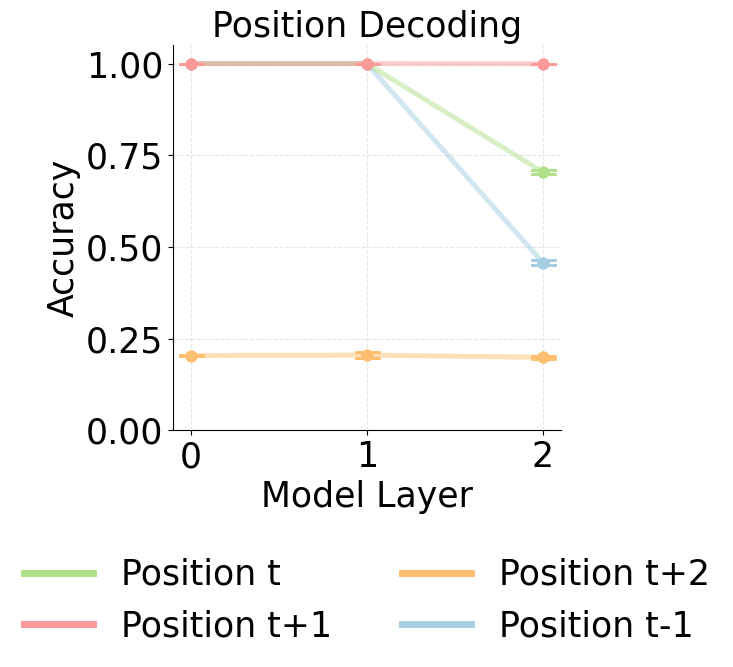

Graph saved to: paper_data/graphs_dir/0130_1949_Position_decoding.pdf


<Figure size 640x480 with 0 Axes>

In [ ]:

results = {"Position": load_results("paper_data/results/position_decoder.pkl")}

metrics = [metric for metric in results["Position"]["model"]]
models = ["baseline", "model"]
layers = [0, 1, 2]
model_lines = {"baseline": "--", "model": "-"}

linestyles = {
    metric: {
        model: model_lines[model]
        for model in models
    }
    for metric in metrics
}

cmap = plt.get_cmap("Paired")
colors = {
    m: {mod: cmap((i * 2) )[:3] for mod in models}
    for i, m in enumerate(metrics)
}

for type, result in results.items():
    ylabels = {}
    for metric in metrics:
        parts = metric.split("_")
        print(parts)


        p = int(parts[-2].replace("pos", "").replace("+", "")) 
        l = int(parts[-1].replace("label", "").replace("+", ""))

        if p == 0:
            ylabels[metric] =f"{type} t"
        elif p > 0:
            ylabels[metric] = f"{type} t+{p}"
        else:
            ylabels[metric] = f"{type} t{p}"


    plot_decoder(
        results=result,
        layers=layers,
        metrics_to_plot=metrics,
        ylabels=ylabels,
        colors=colors,
        linestyles=linestyles,
        graphs_dir="paper_data/graphs_dir",
        filename=f"{type}_decoding",
        title=f"{type} Decoding",
    )

['label', '0']
['label', '1']
['label', '2']


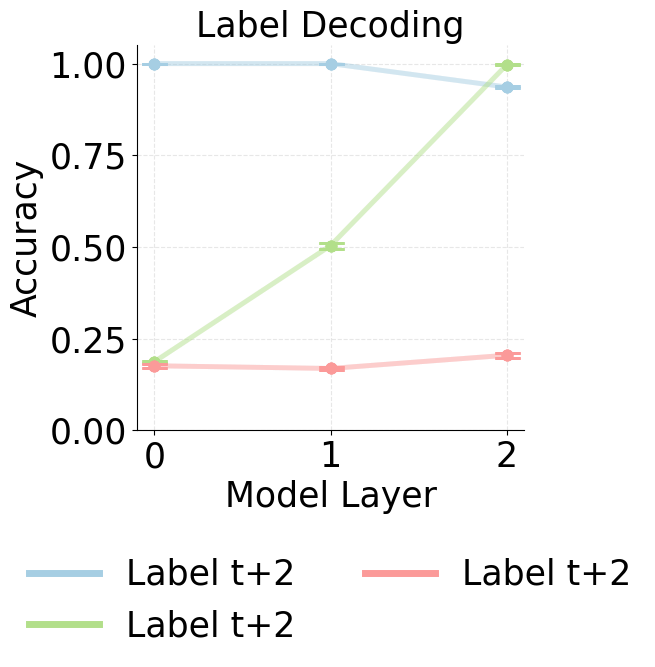

Graph saved to: graphs_dir/0125_1933_Label_decoding.pdf


<Figure size 640x480 with 0 Axes>

In [19]:

results = {"Label": load_results("paper_data/results/label_decoder.pkl")}

metrics = [metric for metric in results["Label"]["model"]]

linestyles = {
    metric: {
        model: model_lines[model]
        for model in models
    }
    for metric in metrics
}

cmap = plt.get_cmap("Paired")
colors = {
    m: {mod: cmap((i * 2) )[:3] for mod in models}
    for i, m in enumerate(metrics)
}

for type, result in results.items():
    ylabels = {}
    for metric in metrics:
        parts = metric.split("_")
        print(parts)

        l = int(parts[-1].replace("label", "").replace("+", ""))

        if p == 0:
            ylabels[metric] =f"{type} t"
        elif p > 0:
            ylabels[metric] = f"{type} t+{p}"
        else:
            ylabels[metric] = f"{type} t{p}"



    plot_decoder(
        results=result,
        layers=layers,
        metrics_to_plot=metrics,
        ylabels=ylabels,
        colors=colors,
        linestyles=linestyles,
        graphs_dir="paper_data/graphs_dir",
        filename=f"{type}_decoding",
        title=f"{type} Decoding",
    )

**Tuple Decoding:**



Graph saved to: paper_data/graphs_dir/0125_1947_tuple_expectation.pdf


/Users/arielventura/code_projects/klab/simple_gpn_interpretability/utils.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


'paper_data/graphs_dir/0125_1947_tuple_expectation.pdf'

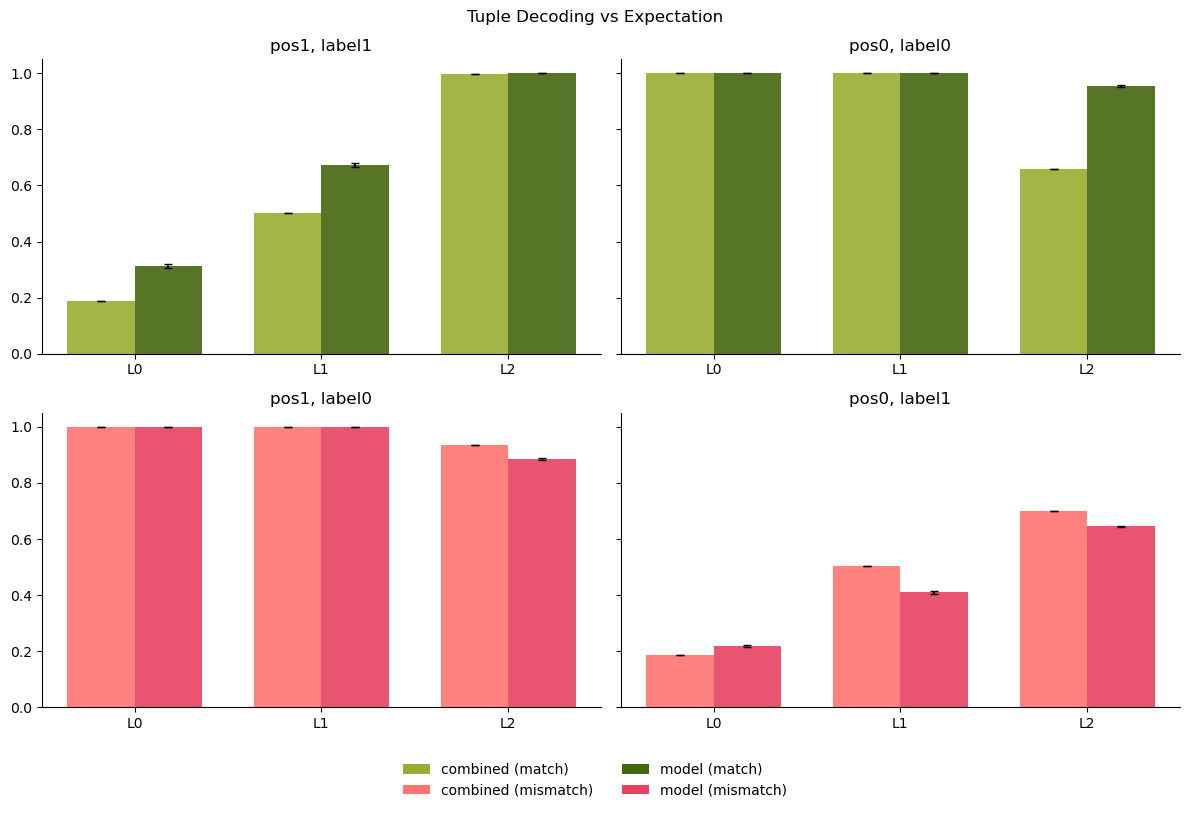

In [24]:
import pprint


models = ["model", "baseline"]
layers = [0, 1, 2]
offsets = [(0,0), (1,1)]
results = {m: {} for m in models}
allowed_offsets = {0, 1}
paths = {
        "tuple":    "paper_data/results/tuple_decoder.pkl",
        "combined":  "paper_data/results/combined_label_position_decoder.pkl"
    }
loaded = load_metric_files(paths)
results = merge_results(loaded)
finalize_metrics(results)

fig = plot_pos_label_panels(results, model_name="model")
save_plot(fig,"paper_data/graphs_dir","tuple_expectation")

**Intervention Analyses**

In [41]:
changed_seqs = load_world_sequences("paper_data/sequences/change_at_35.pkl")
addition_seqs_35 = load_world_sequences("paper_data/sequences/add_at_35.pkl")
addition_seqs_100 = load_world_sequences("paper_data/sequences/add_at_100.pkl")
moved_k_seqs = load_world_sequences("paper_data/sequences/always_k.pkl")

**Token Change:**

Graph saved to: graphs_dir/0125_2017_Changed_VS_Unchanged_Accuracy.pdf


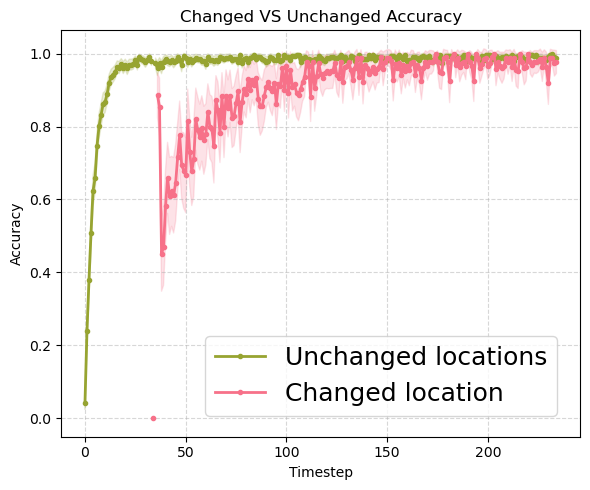

In [53]:
timesteps, acc_hidden, ci_hidden, acc_other, ci_other, n_hidden, n_other = compute_binned_accuracy( model=model, world_seqs=changed_seqs, device=device, property_fn1=lambda t: t.old_label)
plot_binned_accuracy(
    timesteps=timesteps, p_hidden=acc_hidden, ci_hidden=ci_hidden, p_other=acc_other, ci_other=ci_other, 
    label_modified="Changed location", label_other="Unchanged locations", title="Changed VS Unchanged Accuracy")


**Token Change Origin:**

loading checkpoint paper_data/model/final_epoch_79.pth
Graph saved to: graphs_dir/0125_2007_Error_Origin_in_Timesteps_35–65.pdf


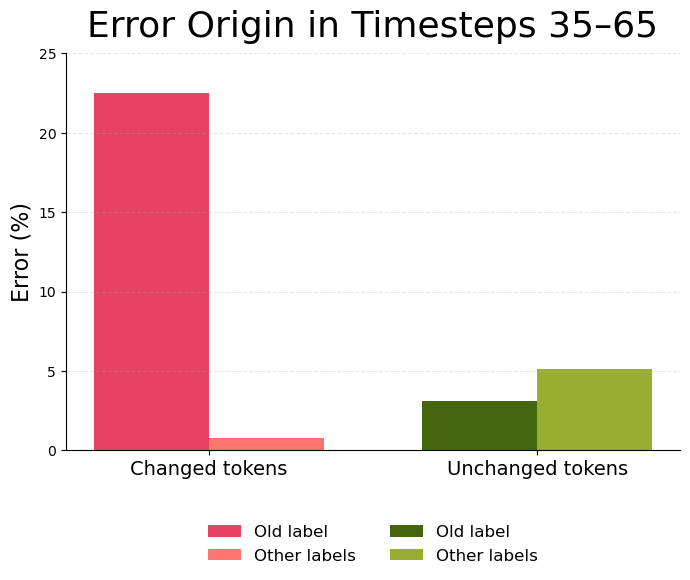

Graph saved to: graphs_dir/0125_2007_Error_Origin_in_Timesteps_180–210.pdf


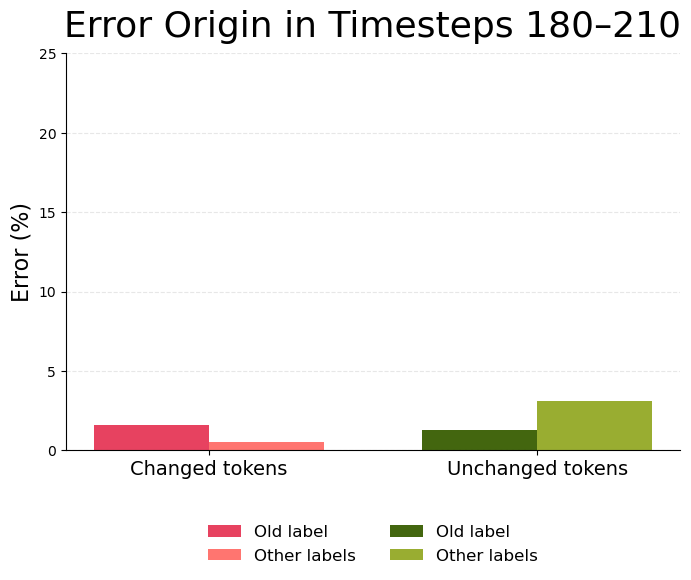

In [44]:

model = GP_model(tokens_size=26, directions_size=2,
                   embedding_size=200, hidden_size=512, output_size=26,
                   n_layers=3, layer_norm=False, dropout=0.0)
model = load_model(model, device, "paper_data/model")

for phase, window in [ ("relearning", (35,65)),("learned", (180, 210)) ]:
    counts = analyze_changed_errors(model, changed_seqs, window)
    proportion = counts["total_errors"] / counts["total_steps"] if counts["total_steps"] else 0
    plot_changed_errors_bar(counts, "graphs_dir", analysis_window=window)


**Token Addition Error:**

Graph saved to: graphs_dir/0125_2018_Added_VS_Unchanged_Accuracy.pdf


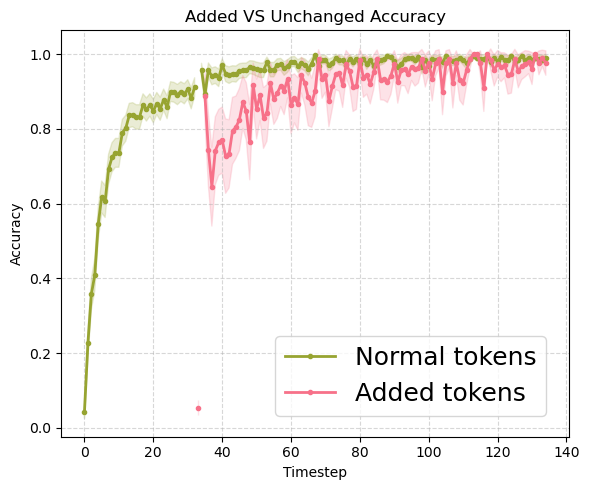

Graph saved to: graphs_dir/0125_2018_Added_VS_Unchanged_Accuracy.pdf


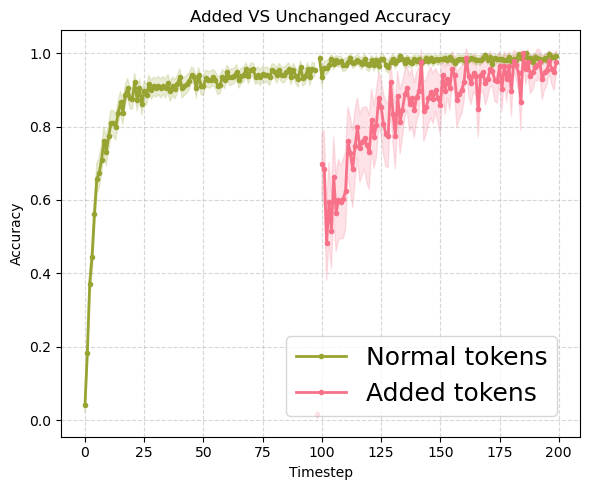

In [54]:
timesteps, acc_hidden, ci_hidden, acc_other, ci_other, n_hidden, n_other  = compute_binned_accuracy( model=model, world_seqs=addition_seqs_35, device=device, property_fn1=lambda t: t.hidden)
plot_binned_accuracy(
    timesteps, p_hidden=acc_hidden, ci_hidden=ci_hidden, p_other=acc_other, ci_other=ci_other, 
    label_modified="Added tokens", label_other="Normal tokens", title="Added VS Unchanged Accuracy")


timesteps, acc_hidden, ci_hidden, acc_other, ci_other, n_hidden, n_other  = compute_binned_accuracy( model=model, world_seqs=addition_seqs_100, device=device, property_fn1=lambda t: t.hidden)
plot_binned_accuracy(
    timesteps, p_hidden=acc_hidden, ci_hidden=ci_hidden, p_other=acc_other, ci_other=ci_other, 
    label_modified="Added tokens", label_other="Normal tokens", title="Added VS Unchanged Accuracy")


**Tuple Generalization:**

Graph saved to: graphs_dir/0125_2019_Non-Fixed_K_Accuracy.pdf


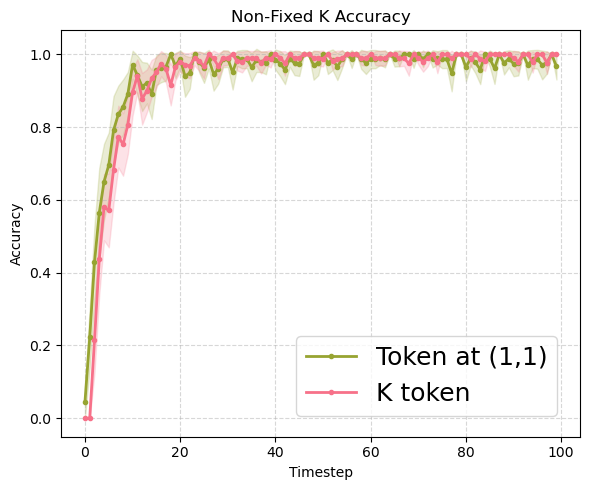

In [57]:
timesteps, acc_k, ci_k, acc_coord, ci_coord, n_k, n_coord = compute_binned_accuracy(
model=model, world_seqs= moved_k_seqs, device=device,
property_fn1=lambda t: t.label == "k",
property_fn2=lambda t: t.coordinates == (1,1),
)
plot_binned_accuracy(
    timesteps=timesteps, p_hidden=acc_k, ci_hidden=ci_k, p_other=acc_coord, ci_other=ci_coord,
    label_modified="K token", label_other="Token at (1,1)", title="Non-Fixed K Accuracy")